In [1]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy
import math
from scipy.stats import poisson
from scipy.stats import ncx2
from scipy.stats import skellam
from scipy.optimize import minimize
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import dask.array as dask
import os
from rpy2.robjects import numpy2ri
numpy2ri.activate()

stats = importr("stats")
#utils = importr('utils')
#utils.install_packages("skellam", repo="http://cran.r-project.org", dep=True)
skel = importr("skellam")

os.system("taskset -p 0xff %d" % os.getpid())

pid 8167's current affinity mask: ff
pid 8167's new affinity mask: ff


0

In [2]:
data_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_ccube.fits')
cmap_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_cmap.fits')
model_file = get_pkg_data_filename('allsky_counts_model.fits')
diffuse_model_file = get_pkg_data_filename('diffuse_only.fits')
#model2_file = get_pkg_data_filename('allsky_counts_ultraclean.fits')
point_model1_file = get_pkg_data_filename('point_only_0_6938_model.fits')
point_model2_file = get_pkg_data_filename('point_only_6939_14007_model.fits')
point_model3_file = get_pkg_data_filename('point_only_14008_20004_model.fits')
point_model4_file = get_pkg_data_filename('point_only_20005_29999_model.fits')
point_model5_file = get_pkg_data_filename('point_only_30000_40010_model.fits')
point_model6_file = get_pkg_data_filename('point_only_40011_50004_model.fits')
point_model7_file = get_pkg_data_filename('point_only_50005_59998_model.fits')
point_model8_file = get_pkg_data_filename('point_only_59999_model.fits')
exp_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_expcube1.fits')

In [3]:
data_hdu = fits.open(cmap_file)[0]
wcs = WCS(data_hdu.header)

In [4]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [4]:
count_data = fits.getdata(data_file, ext=0)[0]
#cmap_data = fits.getdata(cmap_file, ext=0)
#count_model = fits.getdata(model_file, ext=0)
diffuse_model = fits.getdata(diffuse_model_file, ext=0)[0]
#count_model2 = fits.getdata(model2_file, ext=0)[0]
point_model1 = fits.getdata(point_model1_file, ext=0)[0]
point_model2 = fits.getdata(point_model2_file, ext=0)[0]
point_model3 = fits.getdata(point_model3_file, ext=0)[0]
point_model4 = fits.getdata(point_model4_file, ext=0)[0]
point_model5 = fits.getdata(point_model5_file, ext=0)[0]
point_model6 = fits.getdata(point_model6_file, ext=0)[0]
point_model7 = fits.getdata(point_model7_file, ext=0)[0]
point_model8 = fits.getdata(point_model8_file, ext=0)[0]
#model_data = numpy.vectorize(poisson.rvs)(model_expected)
#exp_data = fits.getdata(exp_file, ext=0)[1]
#model_norm = model_data - numpy.min(model_data)

In [5]:
point_model = numpy.add(point_model1, point_model2)
point_model = numpy.add(point_model, point_model3)
point_model = numpy.add(point_model, point_model4)
point_model = numpy.add(point_model, point_model5)
point_model = numpy.add(point_model, point_model6)
point_model = numpy.add(point_model, point_model7)
point_model = numpy.add(point_model, point_model8)
total_model = numpy.add(point_model, diffuse_model)

In [6]:
dnorm = sum(sum(diffuse_model))
d = diffuse_model/dnorm
p1norm = sum(sum(point_model1))
p1 = point_model1/p1norm
p2norm = sum(sum(point_model2))
p2 = point_model2/p2norm
p3norm = sum(sum(point_model3))
p3 = point_model3/p3norm
p4norm = sum(sum(point_model4))
p4 = point_model4/p4norm
p5norm = sum(sum(point_model5))
p5 = point_model5/p5norm
p6norm = sum(sum(point_model6))
p6 = point_model6/p6norm
p7norm = sum(sum(point_model7))
p7 = point_model7/p7norm
p8norm = sum(sum(point_model8))
p8 = point_model8/p8norm

In [7]:
def image_dot(i1, i2):
    return sum(sum(numpy.multiply(i1, i2)))

In [8]:
def image_conv(z, psfs):
    r = numpy.zeros(psfs[0].shape)
    for i in range(len(z)):
        r = numpy.add(r, z[i]*psfs[i])
    return r

In [9]:
def rl1(psfs, z, data):
    im0 = image_conv(z, psfs)
    rat = numpy.divide(data, im0)
    zk = [0]*len(z)
    for i in range(len(z)):
        zk[i] = z[i]*image_dot(rat, psfs[i])
    return zk

In [10]:
def loss_map(psfs, z, data):
    im0 = image_conv(z, psfs)
    return numpy.subtract(im0, numpy.multiply(data, numpy.log(im0)))
def d2_loss_map(psfs, z, data):
    im0 = image_conv(z, psfs)
    return numpy.square(numpy.subtract(data, im0))
def loss(psfs, z, data, loss_map):
    return sum(sum(loss_map(psfs, z, data)))

In [11]:
def fz(z):
    return loss(psfs, z, count_data, d2_loss_map)

In [12]:
z0 = [dnorm, p1norm, p2norm, p3norm, p4norm, p5norm, p6norm, p7norm, p8norm]
psfs = [d, p1, p2, p3, p4, p5, p6, p7, p8]
zk = z0

In [53]:
zk = rl1(psfs, zk, count_data)
#[i / j for i,j in zip(zk, z0)]
zk

[27267050.61190164,
 417296.2844569714,
 430795.98770341434,
 298115.2277993557,
 900411.0943684814,
 1083138.0546970796,
 1420757.5541429361,
 525235.8322081744,
 225398.8338184257]

In [78]:
zknm = minimize(fz, zk, method='Nelder-Mead')
zknm

 final_simplex: (array([[26030337.10626683,   516065.72230582,   521441.58688954,
          339397.63281673,  1181020.65751283,  1543238.07187989,
         1895126.24691964,   554506.14291797,   247731.48185195],
       [26030337.21621349,   516065.70895866,   521441.57951271,
          339397.61531033,  1181020.66454896,  1543238.07082025,
         1895126.24216906,   554506.11322538,   247731.47724786],
       [26030337.32956553,   516065.72335156,   521441.57935747,
          339397.6089182 ,  1181020.66841951,  1543238.07042778,
         1895126.24446563,   554506.13621506,   247731.48953441],
       [26030337.36826224,   516065.70782256,   521441.60324407,
          339397.61841481,  1181020.66959419,  1543238.07078877,
         1895126.24600066,   554506.13002764,   247731.51103009],
       [26030337.17965942,   516065.72891263,   521441.5885785 ,
          339397.63532993,  1181020.67023802,  1543238.0726783 ,
         1895126.2441339 ,   554506.10515224,   247731.49814892],
   

In [79]:
zfoo = [i*f for i, f in zip([26030337.10626683,   516065.72230582,   521441.58688954,
         339397.63281673,  1181020.65751283,  1543238.07187989,
        1895126.24691964,   554506.14291797,   247731.48185195], [0.98, 0.45, 0.6, 0.5, 0.5, 0.375, 0.45, 0.4, 0.5])]
#loss(psfs, zfoo, count_data, loss_map)

In [81]:
def imshow_molleweide(data, cmap, norm):
    fig = plt.figure(figsize=(30, 15))
    ax = plt.subplot(projection=ccrs.Mollweide())
    #diff = plt.imshow(fits.getdata(data_file, ext=0), origin='lower')
    diff = ax.imshow(numpy.subtract(count_data, im0), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5), transform=ccrs.PlateCarree(), extent=(-180,180,-90,90))
    #ax.grid(color='black')
    #diff = plt.imshow(im0, cmap=plt.cm.viridis, origin='lower', norm=colors.LogNorm())
    plt.colorbar(diff)
    return fig, ax

In [ ]:
#print(loss(psfs, zk, count_data, d2_loss_map))
im0 = image_conv(zfoo, psfs)
#fig = plt.figure(figsize=(30, 15))
#ax = plt.subplot(projection=ccrs.Mollweide())
#diff = plt.imshow(fits.getdata(data_file, ext=0), origin='lower')
#diff = ax.imshow(numpy.subtract(count_data, im0), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5), transform=ccrs.PlateCarree(), extent=(-90,90,-180,180))
#ax.grid(color='black')
#diff = plt.imshow(im0, cmap=plt.cm.viridis, origin='lower', norm=colors.LogNorm())
#plt.colorbar(diff)
imshow_molleweide(numpy.subtract(count_data, im0), plt.cm.seismic, colors.Normalize(vmin=-5,vmax=5))
total_model = im0

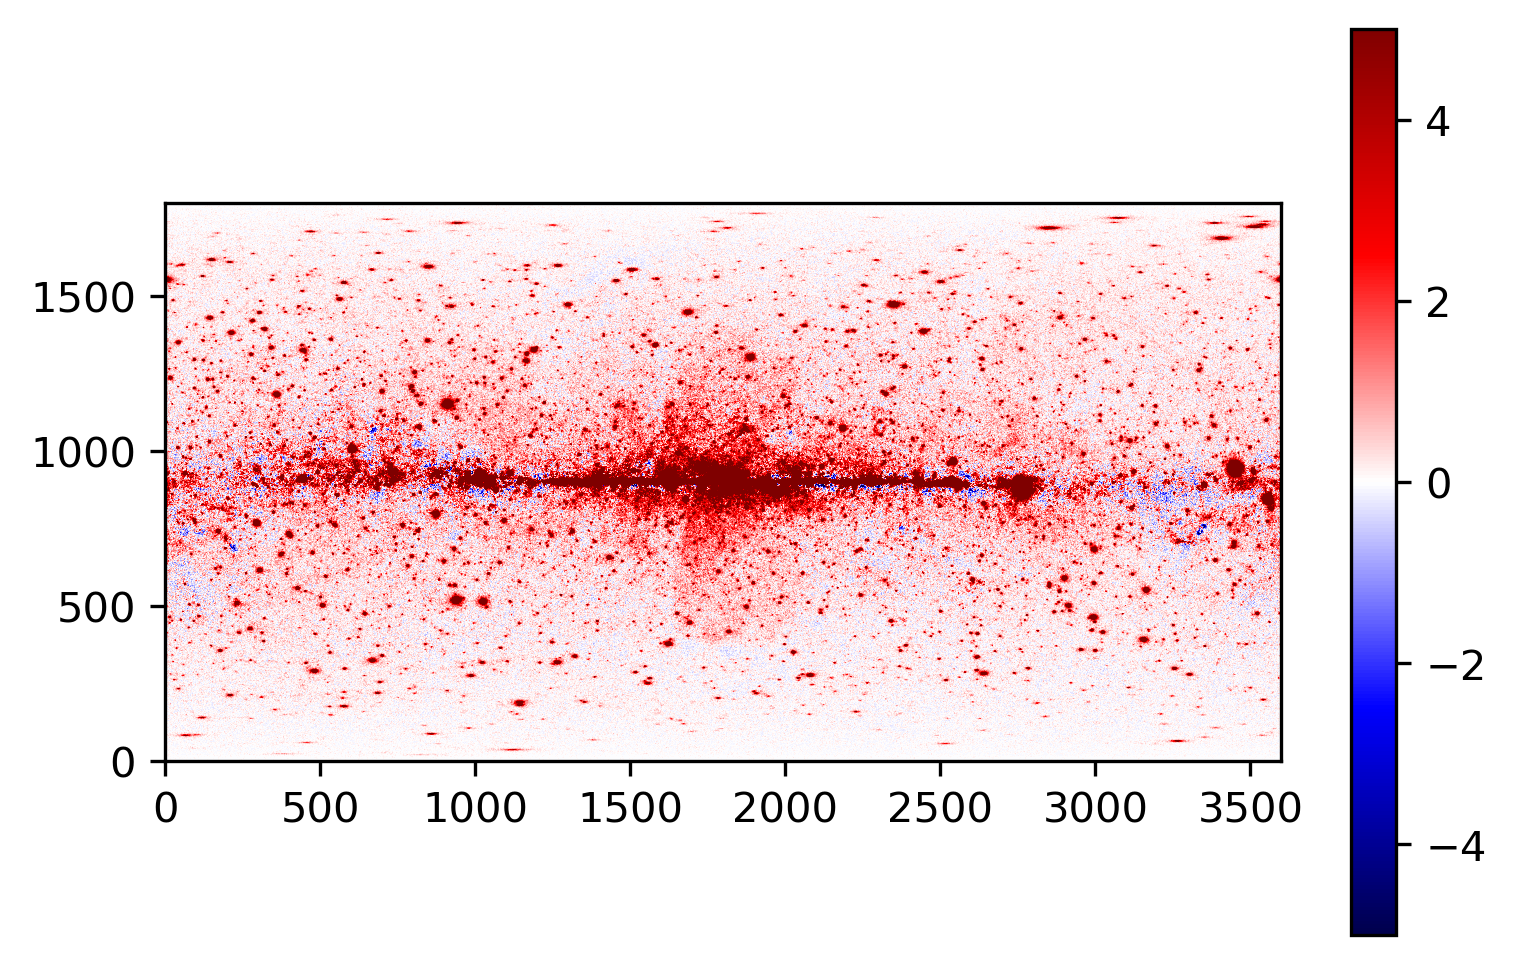

In [20]:
diff = plt.imshow(numpy.subtract(count_data, 0.215*diffuse_model), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5))
plt.colorbar(diff)

In [342]:
def roll_sphere(arr, lat_roll, lon_roll):
    rows, cols = arr.shape
    #rolled = numpy.empty(arr.shape)
    #for row in range(rows):
    #    rolled[row,:] = sphere_row(numpy.roll(arr, lon_roll, 1), row - lat_roll)
    rolled = numpy.roll(arr, lon_roll, 1)
    rolled = numpy.roll(rolled, lat_roll, 0)
    return rolled

In [343]:
def spherify(arr):
    rows, cols = arr.shape
    spharr = numpy.vstack((arr, numpy.flipud(numpy.roll(arr, cols // 2, 1))))
    return spharr

def unspherify(spharr):
    rows, cols = spharr.shape
    return spharr[0:rows//2, :]

def haar_vals(J, j, arr):
    s = 2**(J - j - 1)
    xx = arr
    xr = roll_sphere(arr, 0, s)
    dx = roll_sphere(arr, s, 0)
    dr = roll_sphere(arr, s, s)
    return (xx, xr, dx, dr)

In [344]:
def haar_sums_j(J, j, arr):
    xx, xr, dx, dr = haar_vals(J, j, arr)
    h1 = numpy.add(xx, dx)
    h2 = numpy.add(xr, dr)
    v1 = numpy.add(xx, xr)
    v2 = numpy.add(dx, dr)
    d1 = numpy.add(xx, dr)
    d2 = numpy.add(xr, dx)
    return ((h1, h2), (v1, v2), (d1, d2))

def haar_1(sums):
    (h1, h2), (v1, v2), (d1, d2) = sums
    a = numpy.add(h1, h2) / 2
    h = numpy.subtract(h1, h2) / 2
    v = numpy.subtract(v1, v2) / 2
    d = numpy.subtract(d1, d2) / 2
    return (a, h, v, d)

def haar(arr, jmin=0):
    a = spherify(arr)
    rows, cols = a.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    hs = []
    vs = []
    ds = []
    for j in range(J-1, jmin-1, -1):
        sums = haar_sums_j(J, j, a)
        a, h, v, d = haar_1(sums)
        hs.append(h)
        vs.append(v)
        ds.append(d)
    return a, hs, vs, ds


In [345]:
#cdf_vec = numpy.vectorize(ncx2.cdf)
#sf_vec = numpy.vectorize(ncx2.sf)
def cdf(x, df, nc):
    return stats.pchisq(x, df, nc)
def sf(x, df, nc):
    return 1 - cdf(x, df, nc)
cdf_vec = numpy.vectorize(cdf)
sf_vec = numpy.vectorize(sf)
#cdf_vec = dask.gufunc(cdf, signature="(i),(j),(i)->(i)", output_dtypes=[float], vectorize=True)
#sf_vec = dask.gufunc(sf, signature="(i),(i),(i)->(i)", output_dtypes=[float], vectorize=True)

def skellam_tail(k, mu1, mu2):
    #print(k)
    #print(mu1)
    #print(mu2)
    p = numpy.ones(k.shape)
    diff_mu = numpy.subtract(mu1, mu2)
    sigma_mu = numpy.sqrt(numpy.add(mu1,mu2))
    large = (mu1 >= 1000) | (mu2 > 1000)
    small = ~large
    left = k <= diff_mu
    right = ~left 
    small_left = small & left
    small_right = small & right
    large_left = large & left
    large_right = large & right
    
    if (p[small_left].size > 0):
        print('small_left')
        p[small_left] = skel.pskellam(k[small_left], mu1[small_left], mu2[small_left], lower_tail=True)
    if (p[small_right].size > 0):
        print('small_right')
        p[small_right] = skel.pskellam(k[small_right], mu1[small_right], mu2[small_right], lower_tail=False)
    if (p[large_left].size > 0):
        print('large_left')
        p[large_left] = stats.pnorm(k[large_left], diff_mu[large_left], sigma_mu[large_left], lower_tail=True)
    if (p[large_right].size > 0):
        print('large_right')
        p[large_right] = stats.pnorm(k[large_right], diff_mu[large_right], sigma_mu[large_right], lower_tail=False)
    #print(p)
    return p

def poisson_tail(x, mu):
    p = numpy.ones(x.shape)
    left = x <= mu
    right = x > mu
    p[left] = stats.ppois(x[left] ,mu[left])
    p[right] = stats.ppois(x[right], mu[right], lower_tail=False)
    return p


In [346]:
def haar_threshold(counts, model, alpha, jmin=0, fwer=None):
    a_counts = spherify(counts)
    a_model = spherify(model)
    rows, cols = a_counts.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    hs = []
    vs = []
    ds = []
    for j in range(J-1, jmin-1, -1):
        f = 2**(J - j - 1)
        print(J, j, f, "******************************")
        if (fwer == 'sidak'):
            alpha_j = 1 - (1 - alpha)**(1/(2**(2*j))) #alpha/(2**(2*j)) 
        elif (fwer == 'bonferroni'):
            alpha_j = alpha/2**(2*j)
        else:
            alpha_j = alpha
        print(alpha_j)
        print("sums")
        sums_counts = haar_sums_j(J, j, a_counts)
        a_counts, h_counts, v_counts, d_counts = haar_1(sums_counts)
        sums_model = haar_sums_j(J, j, a_model)
        a_model, h_model, v_model, d_model = haar_1(sums_model)
        (h1, h2), (v1, v2), (d1, d2) = sums_model
        
        print("h threshold")
        hp = skellam_tail(2*f*h_counts, f*h1, f*h2) 
        h_mask = hp < alpha_j/2
        h_model[h_mask] = h_counts[h_mask]
        
        print("v threshold")
        vp = skellam_tail(2*f*v_counts, f*v1, f*v2) 
        v_mask = vp < alpha_j/2
        v_model[v_mask] = v_counts[v_mask]
        
        print("d threshold")
        dp = skellam_tail(2*f*d_counts, f*d1, f*d2)
        d_mask = dp < alpha_j/2
        d_model[d_mask] = d_counts[d_mask]
        
        hs.append(h_model)
        vs.append(v_model)
        ds.append(d_model)
        print(j, "-> Rejected", h_model[h_mask].size, v_model[v_mask].size, d_model[d_mask].size)
    ap = poisson_tail(2*f*a_counts, 2*f*a_model)
    a_mask = ap < alpha_j/2
    ar = a_counts[a_mask]
    a_model[a_mask] = ar
    #a_model = a_counts
    print("Approximation rejected:", ar.size)
    return a_model, hs, vs, ds

In [347]:
def inv_haar_j(J, j, a, h, v, d):
    N = 2**J
    s = 2**(J - j - 1)
    rows, cols = a.shape
    sh = (rows, cols)
    arr = numpy.empty(sh, float)
    ah = numpy.add(a,h)
    av = numpy.add(a,v)
    ad = numpy.add(a,d)
    vd = numpy.add(v,d)
    hd = numpy.add(h,d)
    hv = numpy.add(h,v)
    xx = numpy.add(ah,vd)
    xr = numpy.subtract(av,hd)
    dx = numpy.subtract(ah,vd)
    dr = numpy.subtract(ad,hv)
    spharr = (xx 
            + roll_sphere(xr, 0, -s) 
            + roll_sphere(dx, -s, 0) 
            + roll_sphere(dr, -s, -s)
           ) / 8
    return spharr

def inv_haar(a, hs, vs, ds):
    rows, cols = a.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    nj = len(hs)
    for i in range(nj-1, -1, -1):
        j = J - i - 1
        a = inv_haar_j(J, j, a, hs[i], vs[i], ds[i])
    return unspherify(a)

In [348]:
def zero(n):
    return numpy.zeros((n,n), float)

def checkers(n, p):
    arr = numpy.zeros((n, 2*n), float) + 2
    for row in range(n):
        rq, rr = divmod(row, p)
        row_mult = 1 if rq % 2 == 0 else -1
        for col in range(2*n):
            cq, cr = divmod(col, p)
            col_mult = 1 if cq % 2 == 0 else -1
            arr[row,col] += row_mult*col_mult
    return arr

def delta(n, row, col):
    arr = numpy.zeros((n, 2*n), float) 
    arr[row, col] = 1
    return arr

def stripe(n, rows):
    arr = numpy.zeros((n, 2*n), float) 
    arr[rows, :] = 1
    return arr

In [595]:
#count_model = stripe(30, [13,14,15])*10 + 1
#data_model = 0.225*count_model #+ stripe(30, [13,14,15])*10 #+ 20*delta(30, 15, 15)
#count_data = poisson.rvs(data_model)
#a_model, hs_model, vs_model, ds_model = haar(count_model)
#a_data, hs_data, vs_data, ds_data = haar(count_data)

In [360]:
a, hs, vs, ds = haar_threshold(count_data, total_model, 0.000001, fwer='uniform')
#a, hs, vs, ds = haar_threshold(count_data, count_model, 0.1)

12 11 1 ******************************
1e-06
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
11 -> Rejected 7082 9679 2040
12 10 2 ******************************
1e-06
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
10 -> Rejected 36916 49662 17761
12 9 4 ******************************
1e-06
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
9 -> Rejected 141022 190613 97730
12 8 8 ******************************
1e-06
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
8 -> Reje

In [361]:
count_rec = inv_haar(a, hs, vs, ds)
print(sum(sum(count_data)), sum(sum(total_model)), sum(sum(count_rec)))

32568200 28587579.037930384 32568201.591109946


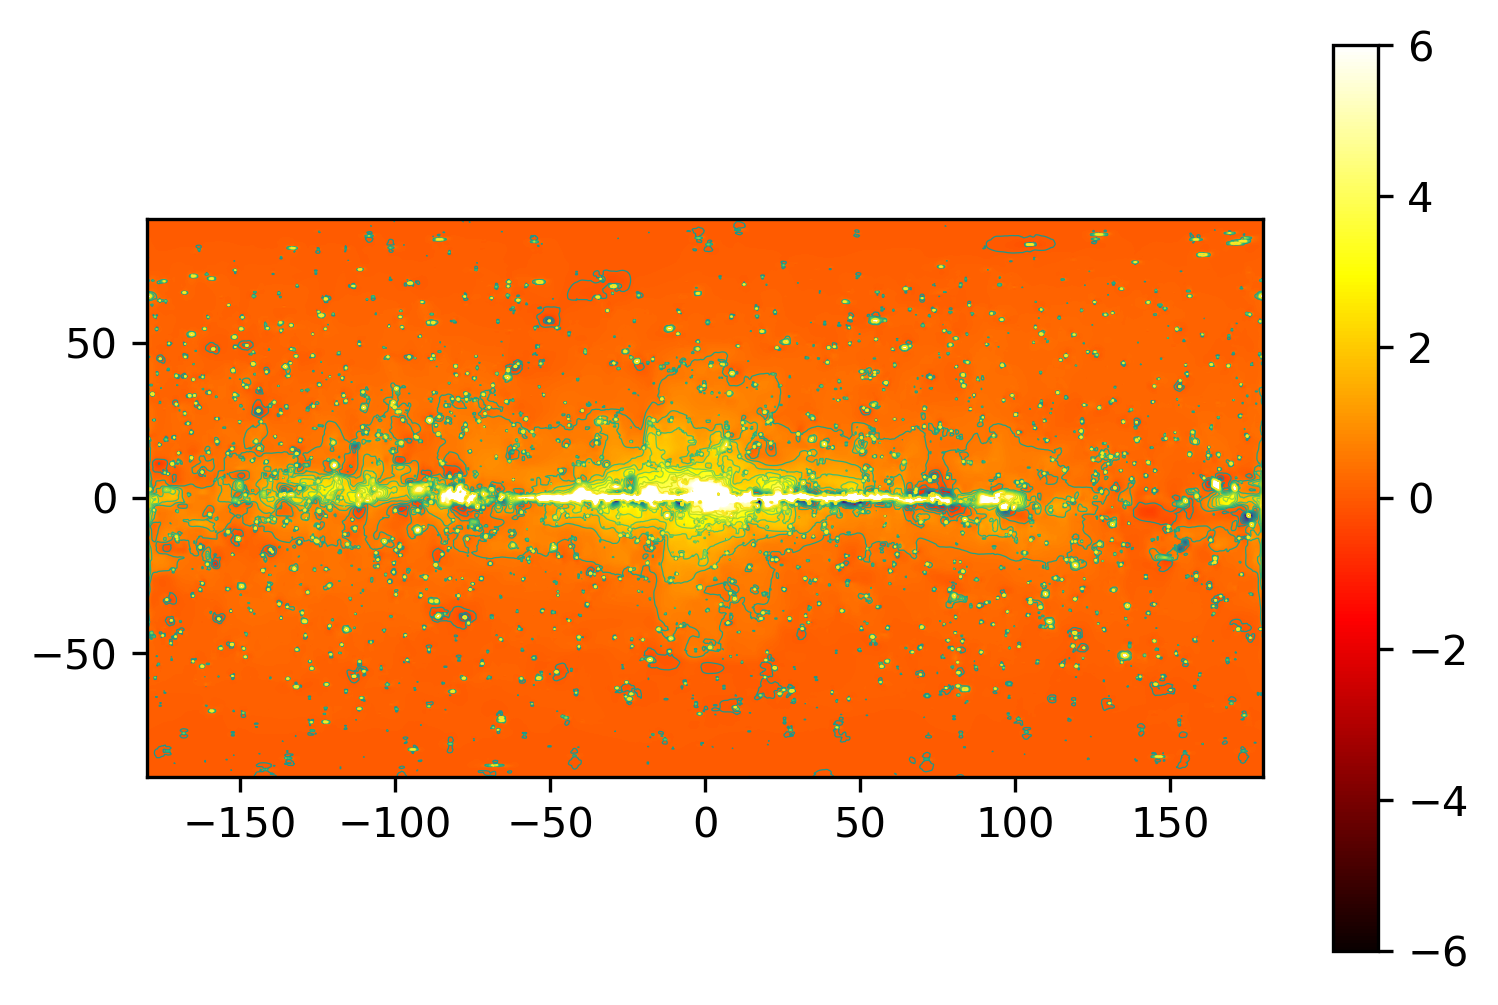

In [389]:
fig, ax = plt.subplots()
foo = plt.imshow(numpy.subtract(count_rec, total_model), cmap=plt.cm.hot, origin='lower', norm=colors.Normalize(vmin=-6,vmax=6), extent=(-180,180,-90,90))
#foo = plt.imshow(numpy.subtract(count_data, 0.225*diffuse_model), cmap=plt.cm.seismic, origin='lower', norm=colors.LogNorm())
#foo = plt.imshow(count_model[500:1300,1400:2200], origin='lower', cmap=plt.cm.magma, norm=colors.LogNorm(vmax=1000))
#foo = plt.imshow(diffuse_model, origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(numpy.subtract(count_model2, count_model), origin='lower', cmap=plt.cm.magma, norm=colors.Normalize(vmax=10))
#foo = plt.imshow(vs[0], origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(numpy.subtract(count_rec, count_model), cmap=plt.cm.magma, origin='lower')
ax.contour(Lat, Lon, numpy.subtract(count_rec, total_model), levels, linewidths=0.3)
plt.colorbar(foo)
#plt.plot(numpy.subtract(count_data, count_rec)[0, :])

In [375]:
lon = numpy.arange(-180, 180, 0.1)
lat = numpy.arange(-90, 90, 0.1)
Lat, Lon = numpy.meshgrid(lon, lat)

/home/dave/anaconda3/envs/fermi/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: linewidths is ignored by contourf
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dave/anaconda3/envs/fermi/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  after removing the cwd from sys.path.


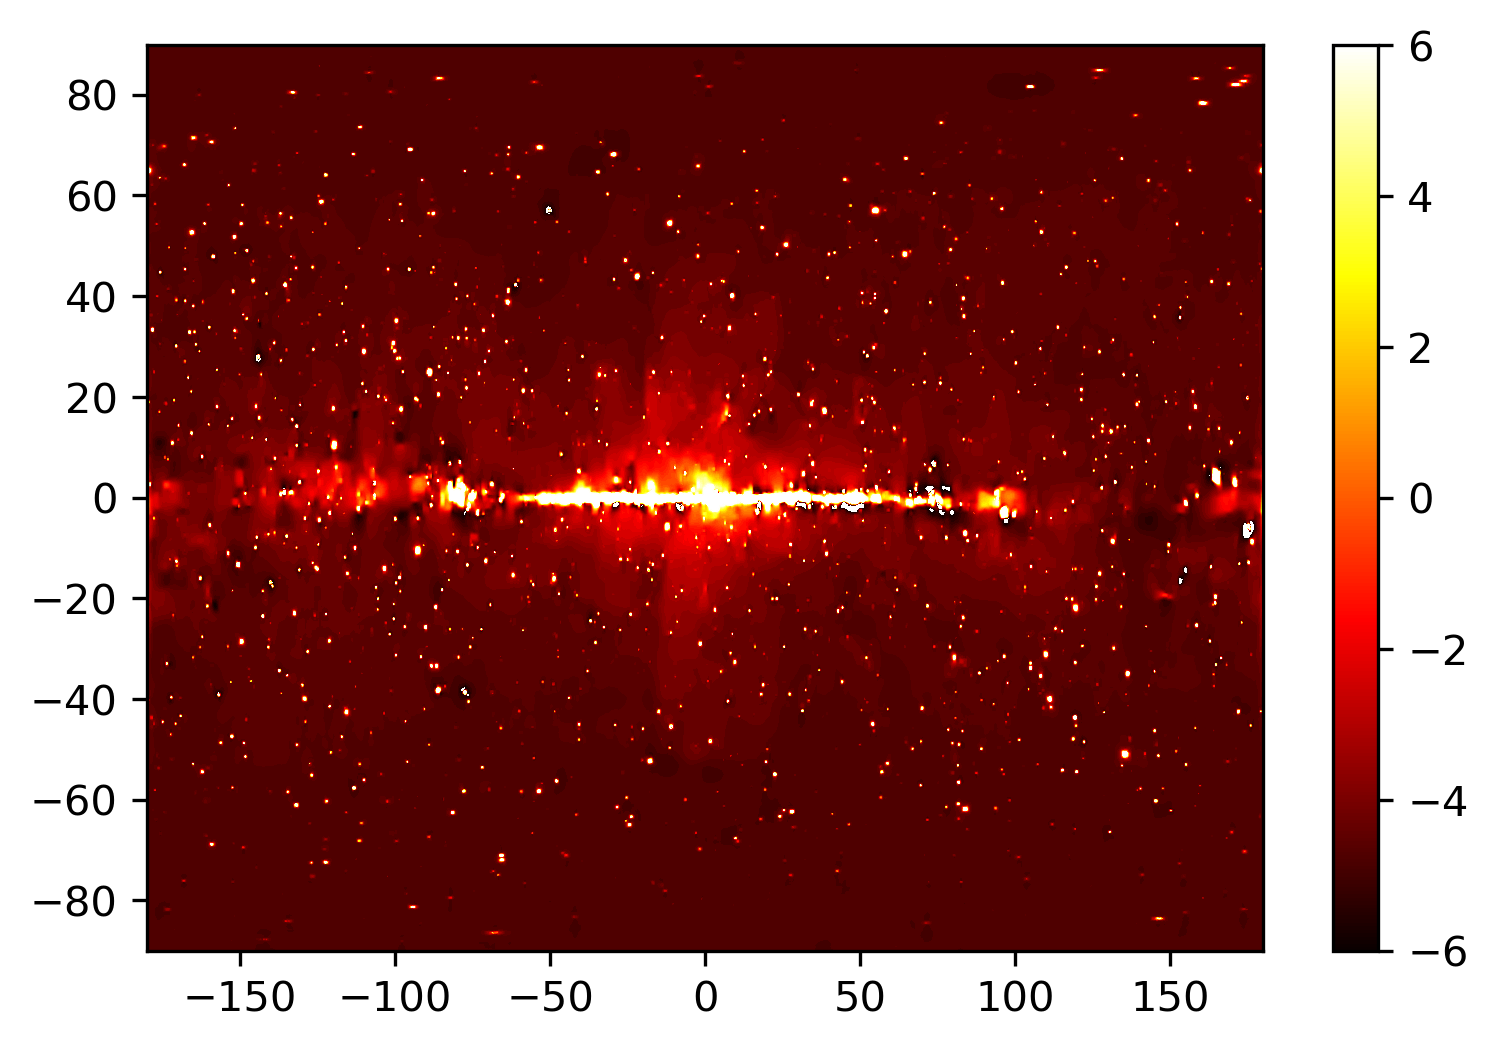

In [401]:
fig, ax = plt.subplots()
levels = numpy.arange(-1, 10, 0.2)
plt.contourf(Lat, Lon, numpy.subtract(count_rec, total_model), levels, cmap=plt.cm.hot, linewidths=0.3)
plt.colorbar(foo)

In [398]:
numpy.logspace(-1,1)

array([ 0.1       ,  0.10985411,  0.12067926,  0.13257114,  0.14563485,
        0.15998587,  0.17575106,  0.19306977,  0.21209509,  0.23299518,
        0.25595479,  0.28117687,  0.30888436,  0.33932218,  0.37275937,
        0.40949151,  0.44984327,  0.49417134,  0.54286754,  0.59636233,
        0.65512856,  0.71968567,  0.79060432,  0.86851137,  0.95409548,
        1.04811313,  1.1513954 ,  1.26485522,  1.38949549,  1.52641797,
        1.67683294,  1.84206997,  2.02358965,  2.22299648,  2.44205309,
        2.6826958 ,  2.9470517 ,  3.23745754,  3.55648031,  3.90693994,
        4.29193426,  4.71486636,  5.17947468,  5.68986603,  6.25055193,
        6.86648845,  7.54312006,  8.28642773,  9.10298178, 10.        ])

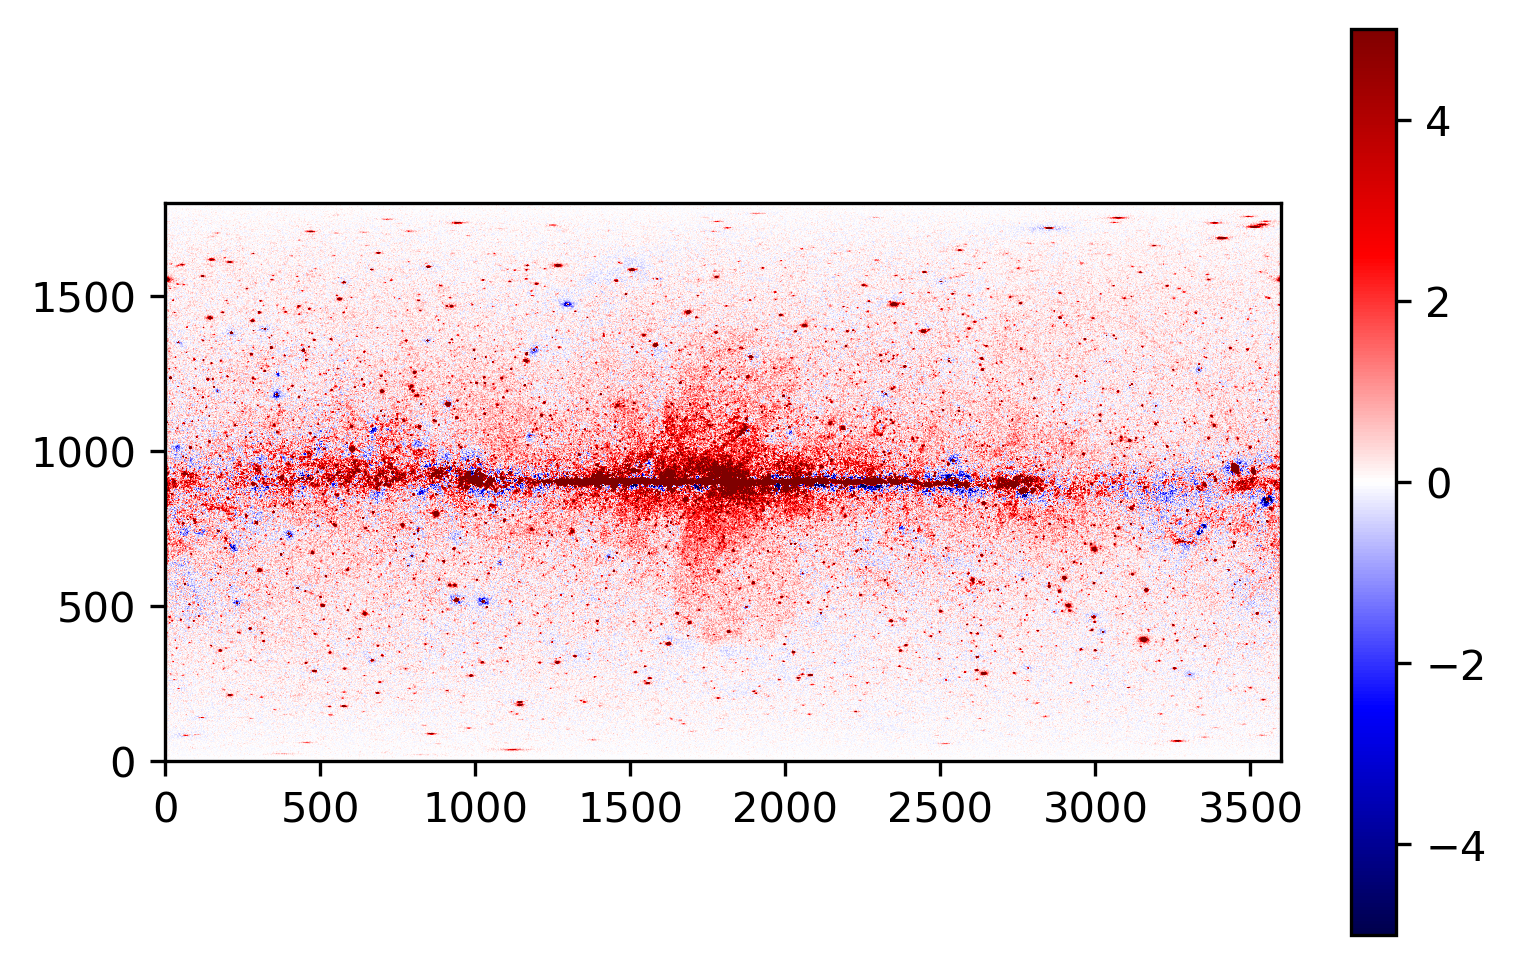

In [354]:
foo = plt.imshow(numpy.subtract(count_data, total_model), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5))
plt.colorbar(foo)

In [357]:
fig.savefig("2021-12-31_1_500_GeV_sidak_001.png")

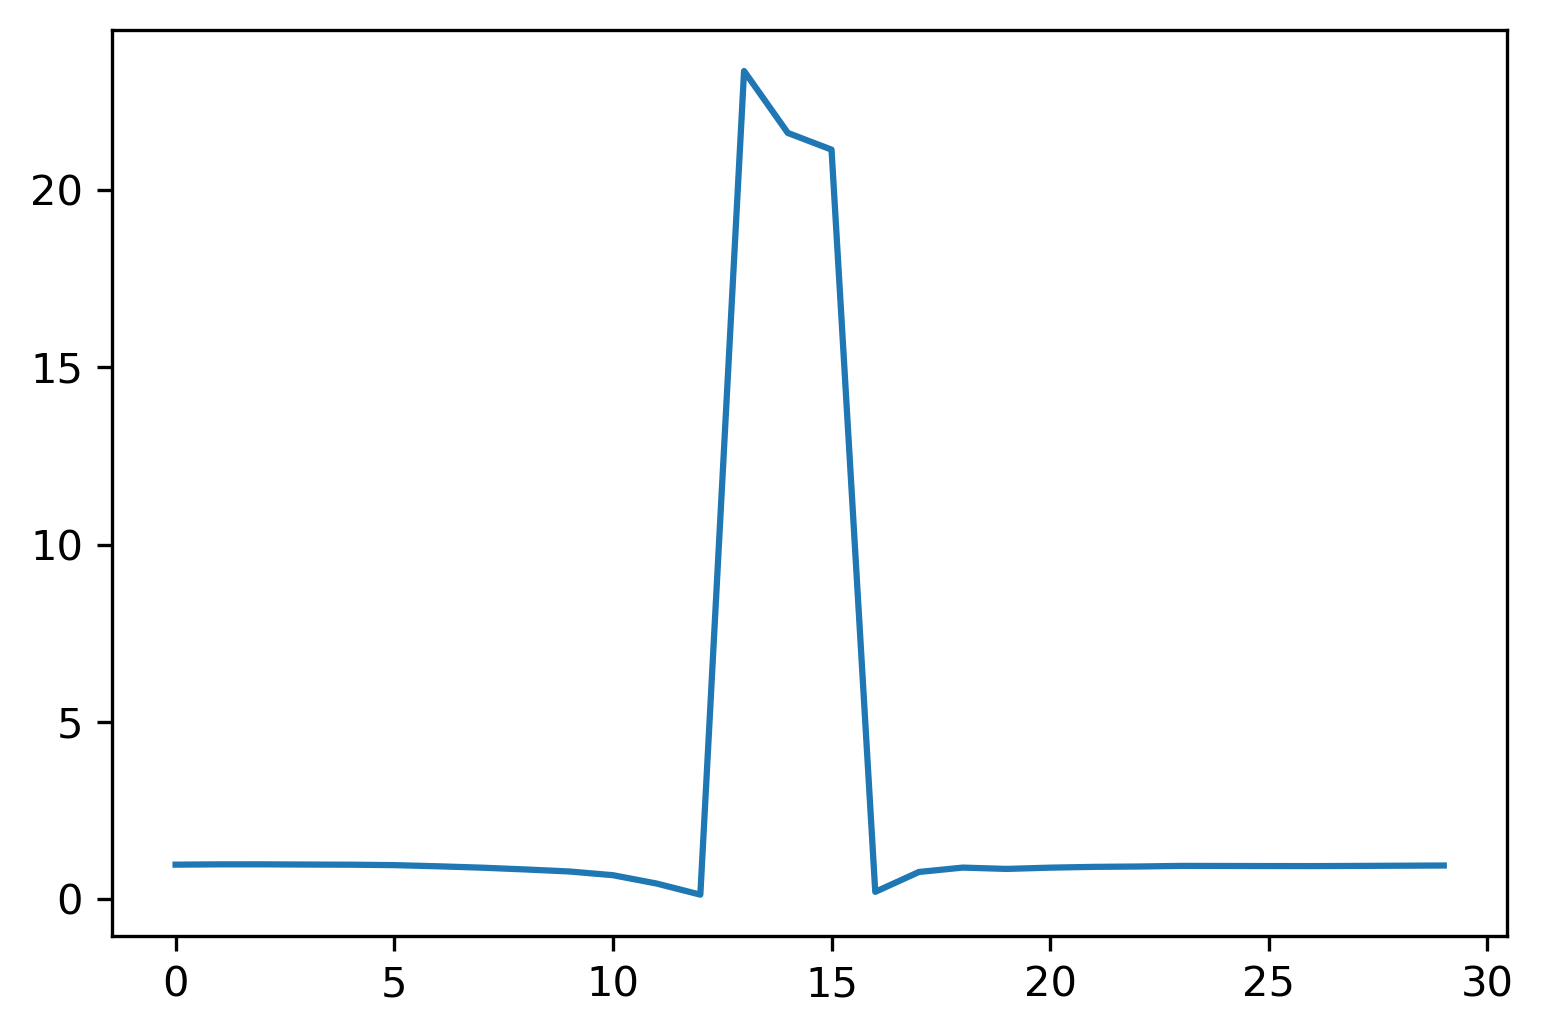

In [538]:
#plt.plot(numpy.subtract(count_rec, 0.225*count_model)[:, 1700])
plt.plot(count_rec[:, 15])

In [358]:
numpy.savez_compressed("2021-12-31_sidak_001.npz", a=a,hs=hs,vs=vs,ds=ds)

In [359]:
del a, hs, vs, ds

In [62]:
print(sum(sum(count_data)))
print(sum(sum(a)))
print(sum(sum(a2)))
print(sum(sum(a_rec)))
print(sum(sum(count_rec)))
sum(sum(a))/sum(sum(count_data))

32568200
65136400.0
130272792.0
65136396.0
32568200.0


2.0

In [418]:
#foo = plt.imshow(roll_sphere(dx, -1, 0), origin='lower')
#plt.colorbar(foo)
roll_sphere(roll_sphere(im, 1, 0), -1, 0)

1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0
9 0 9 0 0
10 1 0 9 5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9 0 9 0 -4
0 0 0 9 0
1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [188]:
a, h, v, d = haar_j(12, 11, count_data)

In [192]:
a10, _, _, _ = haar_j(12, 10, a)
a9, _, _, _ = haar_j(12, 9, a10)
a8, _, _, _ = haar_j(12, 8, a9)
a7, _, _, _ = haar_j(12, 7, a8)
a6, _, _, _ = haar_j(12, 6, a7)
a5, _, _, _ = haar_j(12, 5, a6)
a4, _, _, _ = haar_j(12, 4, a5)
a3, _, _, _ = haar_j(12, 3, a4)
a2, _, _, _ = haar_j(12, 2, a3)
a1, _, _, _ = haar_j(12, 1, a2)

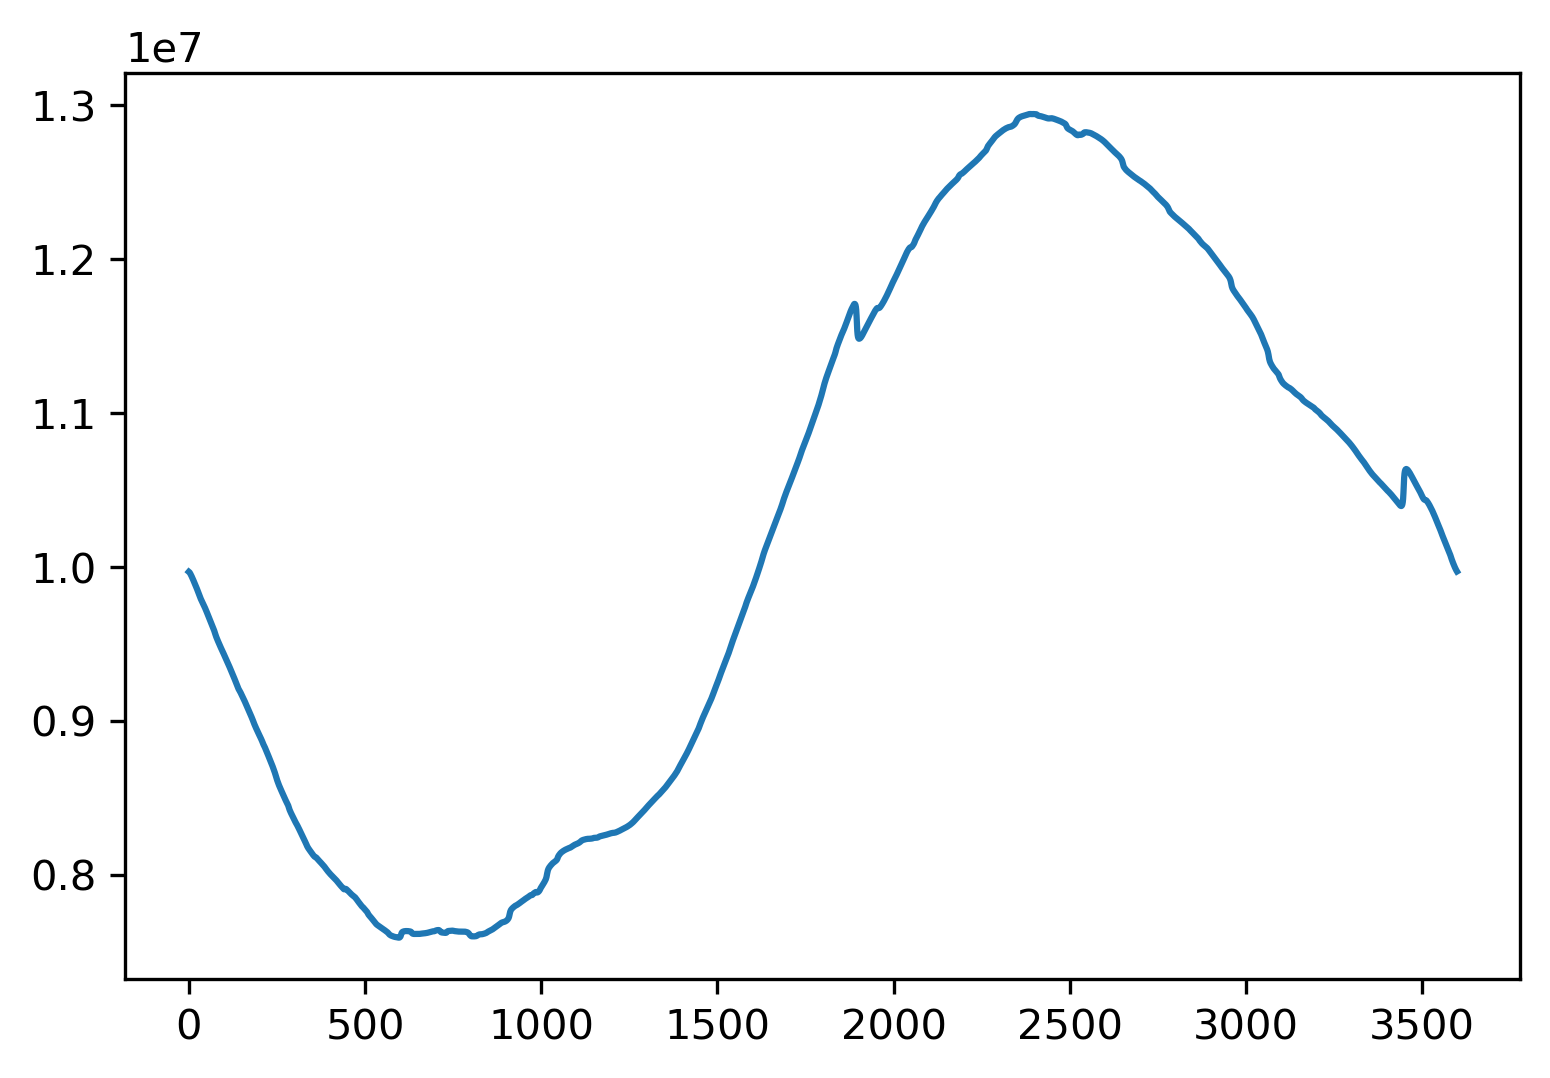

In [194]:
plt.plot(a1[900, :])

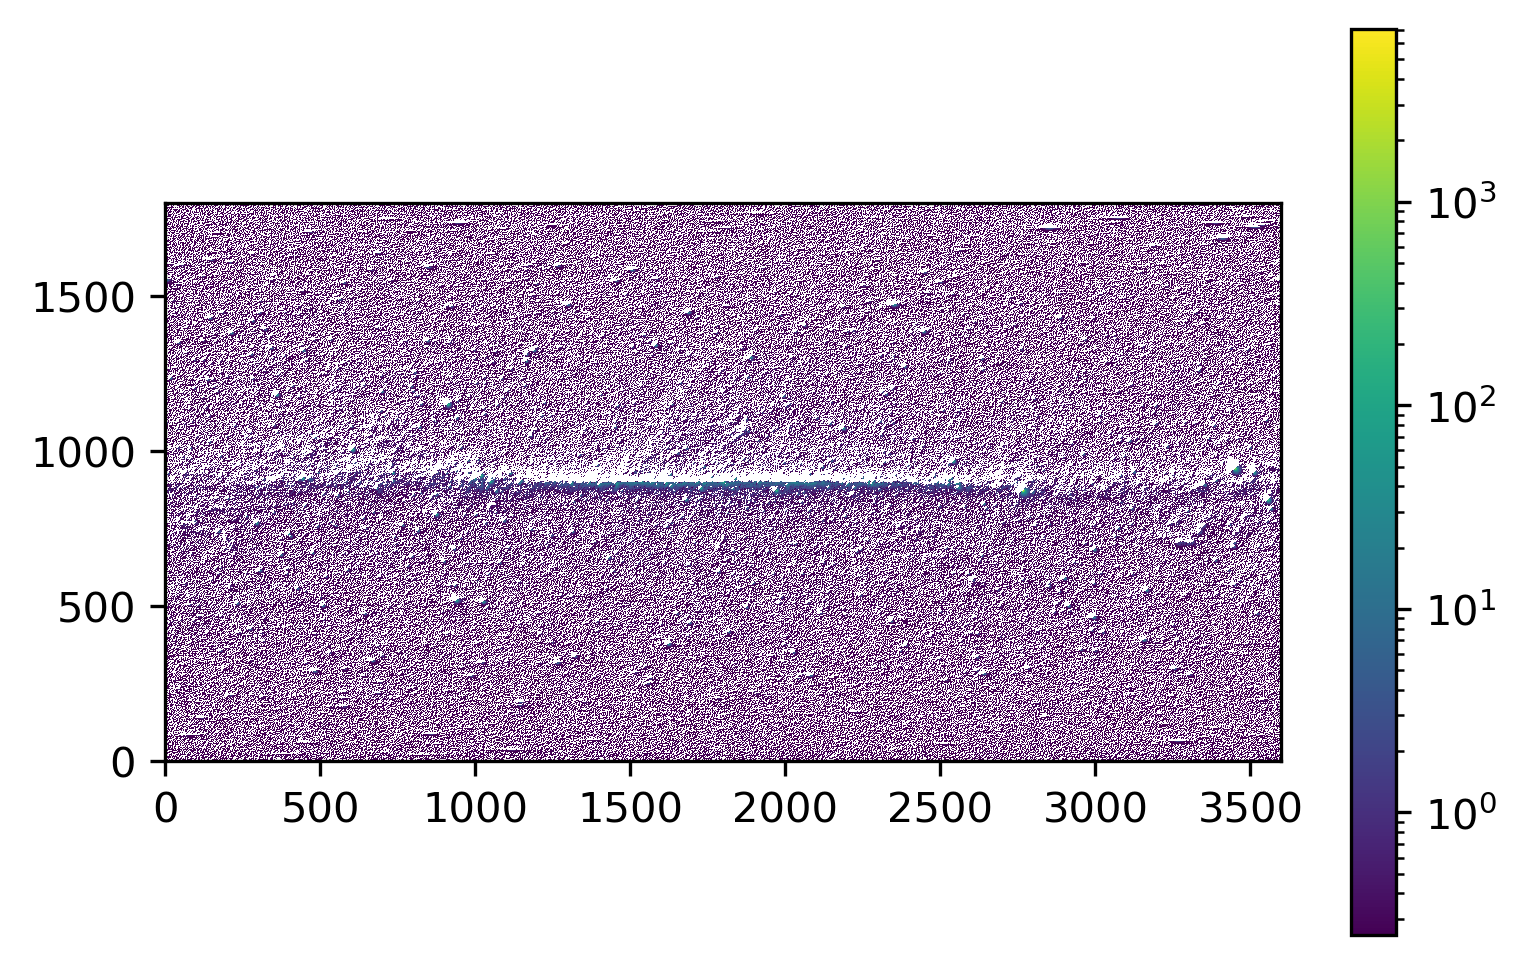

In [215]:
diff = plt.imshow(numpy.subtract(a / 4, count_data), origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [109]:
2**12

4096

In [16]:
ax.set_xlim(-180,180)

(-180.0, 180.0)

In [17]:
overlay = ax.get_coords_overlay('fk5')

In [18]:
overlay.grid(color='black', ls='dotted')